## Task 1 - Part 1

#### Step 1 − Import the necessary packages

In [84]:
# Importar bibliotecas necessárias
import numpy as np
import random
import matplotlib.pyplot as plt  # Corrigido plt00 para plt
from sklearn.linear_model import Ridge, Lasso, RANSACRegressor, LinearRegression  # Unificado as importações do sklearn.linear_model
from sklearn.model_selection import GridSearchCV, train_test_split  # Unificado imports de model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels import robust  # statsmodels não conflita com sklearn, então permanece
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


#### Step 1.5 − Picture visulazer

In [85]:
# Função para visualizar as imagens
def img_view (dataset, labels=None, num_imgs=5):
    """
    Função que visualiza um número especificado de imagens.
    
    Parâmetros:
    - dataset: Conjunto de imagens a visualizar.
    - labels: (Opcional) Rótulos das imagens, se disponíveis.
    - num_imgs: Número de imagens a visualizar.
    """
    # Verificar quantas imagens existem no dataset
    num_imgs = min(num_imgs, len(dataset))  # Garante que não tentas visualizar mais imagens do que as disponíveis

    # Criar a figura para visualização
    plt.figure(figsize=(10, 10))
    
    for i in range(num_imgs):
        plt.subplot(1, num_imgs, i+1)
        plt.imshow(dataset[i], cmap='gray')  # Usar 'gray' para imagens em escala de cinza
        plt.axis('off')
        
        if labels is not None:
            plt.title(f"Label: {labels[i]}")

    plt.show()

#### Step 2 − Load the dataset

X_train shape antes do reshape: (2783, 2304)
X_train shape depois do reshape: (2783, 48, 48)


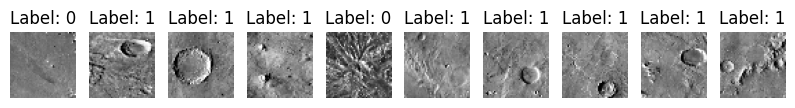

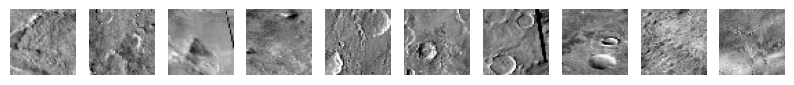

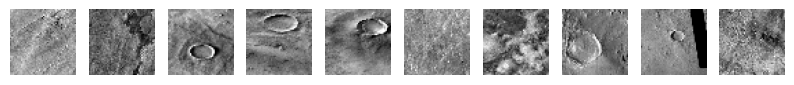

In [86]:
# Carregar os dados
X_test = np.load('Xtest1.npy')
X_train = np.load('Xtrain1.npy')
Y_train = np.load('Ytrain1.npy')
X_train_extra = np.load('Xtrain1_extra.npy')

# Verificar as dimensões dos datasets antes do reshape
print(f"X_train shape antes do reshape: {X_train.shape}")

# Reformatar as imagens para o formato correto (48, 48)
X_train = X_train.reshape(-1, 48, 48)
X_test = X_test.reshape(-1, 48, 48)
X_train_extra = X_train_extra.reshape(-1, 48, 48)

print(f"X_train shape depois do reshape: {X_train.shape}")
#############################################3
# Variável para controlar quantas imagens queres visualizar
num_imagens = 10  # Podes alterar este número para visualizar mais ou menos imagens
#######################################3


# Visualizar imagens de treino com rótulos
img_view(X_train, Y_train, num_imgs=num_imagens)

# Visualizar imagens de teste (sem rótulos)
img_view(X_test, num_imgs=num_imagens)

# Visualizar imagens do dataset extra (sem rótulos)
img_view(X_train_extra, num_imgs=num_imagens)


#### Step 2.5 - processamento

In [87]:
# 2. Preprocessamento: Reshape e Normalização
# Ajustar a forma das imagens para (48, 48, 1) para incluir o canal de cor (grayscale)
# A CNN espera 4 dimensões: (número de amostras, altura, largura, número de canais)
X_train = X_train.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

# Normalizar os valores dos píxeis para estar entre 0 e 1, dividindo por 255
# Isto ajuda o modelo a convergir melhor durante o treino
X_train = X_train / 255.0
X_test = X_test / 255.0

#(X).astype('float32')/255.0

# Verificar novamente a forma após o reshape
print(f"Forma de X_train depois do reshape: {X_train.shape}")
print(f"Forma de X_test depois do reshape: {X_test.shape}")

# Dividir o conjunto de treino em treino e validação (20% dos dados para validação)
# O conjunto de validação é usado para verificar a performance do modelo durante o treino
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.4, random_state=42)


Forma de X_train depois do reshape: (2783, 48, 48, 1)
Forma de X_test depois do reshape: (696, 48, 48, 1)


#### Step 3 −Definir a arquitetura da cnn 

In [88]:
# 3. Definir a CNN (Convolutional Neural Network)
# Modelo sequencial permite adicionar camadas uma após a outra
model_relu = Sequential()

# Primeira camada convolucional:
# - 32 filtros (kernels) de 3x3
# - Função de ativação 'ReLU' (Rectified Linear Unit)
# - Input shape é 48x48 com 1 canal (grayscale)
model_relu.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
# MaxPooling reduz a dimensionalidade: Reduz o tamanho da imagem de 48x48 para 24x24
model_relu.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda camada convolucional:
# - 64 filtros de 3x3
# - MaxPooling reduz ainda mais a dimensão para 12x12
model_relu.add(Conv2D(64, (3, 3), activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2, 2)))

# Terceira camada convolucional:
# - 128 filtros de 3x3
# - MaxPooling reduz para 6x6
model_relu.add(Conv2D(128, (3, 3), activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten: Converter as saídas convolucionais 3D em um vetor 1D para a camada totalmente conectada
model_relu.add(Flatten())

# Camada densa (fully connected):
# - 128 neurónios
# - Dropout com taxa de 50% para evitar overfitting
model_relu.add(Dense(128, activation='relu'))
model_relu.add(Dropout(0.5))  # Desativa aleatoriamente 50% dos neurónios durante o treino

# Camada de saída:
# - 1 neurónio com ativação 'sigmoid' (porque estamos a fazer classificação binária: crater ou não crater)
model_relu.add(Dense(1, activation='sigmoid'))


c:\Users\Duarte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


####Step 3 - Compilar o modelo

In [89]:
# 4. Compilar o modelo
# - Otimizador 'adam': uma versão otimizada do gradiente descendente
# - Função de perda 'binary_crossentropy': apropriada para problemas de classificação binária
# - Métrica 'accuracy': avalia a percentagem de previsões corretas

optimizer = Adam(learning_rate=0.001)  # Exemplo: learning rate de 0.001 é padrao 
model_relu.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


#### Step 4.1 - Treinar o modelo 

In [90]:
# 5. Treinar o modelo
# - Usamos o método .fit() para treinar o modelo nos dados de treino
# - Validação é monitorizada ao usar o conjunto de validação
# - O treino ocorre por 15 épocas com um batch size de 32 (pode-se ajustar esses valores)
history = model_relu.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_val, Y_val))

# O objeto "history" guarda a precisão e a perda de cada época, útil para gráficos


Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6152 - loss: 0.6354 - val_accuracy: 0.8106 - val_loss: 0.5374
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8156 - loss: 0.5112 - val_accuracy: 0.8178 - val_loss: 0.4443
Epoch 3/15
35/53 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8343 - loss: 0.4097

KeyboardInterrupt: 

#### Step 4 - With regularization


In [77]:
# 6. Avaliar o modelo no conjunto de teste
# - Usamos o método .evaluate() para testar o modelo nos dados não vistos
# - Ele retorna a perda e a métrica (neste caso, accuracy)
#test_loss, test_acc = model.evaluate(X_test, verbose=2)
#print(f"Test accuracy: {test_acc}")


#### Step 7 − View model


In [ ]:
import matplotlib.pyplot as plt

# Função para plotar a acurácia de treino e validação
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Treino')
    plt.plot(history.history['val_accuracy'], label='Validação')
    plt.xlabel('Épocas')
    plt.ylabel('precisao')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title('Evolução da precisao')
    plt.show()

# Função para plotar a perda de treino e validação
def plot_loss(history):
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend(loc='upper right')
    plt.title('Evolução da Perda')
    plt.show()

# Chamada das funções após treinar o modelo
plot_accuracy(history)
plot_loss(history)


In [ ]:
# Vamos mostrar as primeiras 10 imagens do conjunto de validação e seus rótulos correspondentes
# 0 - Sem cratera
# 1 - Com cratera

def visualizar_imagens_validacao(X_val, Y_val, num_imagens=10):
    plt.figure(figsize=(15, 15))
    
    for i in range(num_imagens):
        plt.subplot(1, num_imagens, i + 1)
        plt.imshow(X_val[i].reshape(48, 48), cmap='gray')  # Exibimos a imagem em escala de cinza
        plt.title(f"Label: {Y_val[i]}")
        plt.axis('off')  # Desativa os eixos
        
    plt.show()

# Chamar a função para visualizar as primeiras 10 imagens e seus rótulos
visualizar_imagens_validacao(X_val, Y_val, num_imagens=10)


In [ ]:
from sklearn.metrics import f1_score

# Fazer previsões no conjunto de validação (X_val)
# O modelo gera probabilidades, então usamos um limiar de 0.5 para classificar
Y_pred_val = model.predict(X_val)
Y_pred_val = np.round(Y_pred_val).astype(int)  # Converter para 0 ou 1

# Calcular o F1 Score
f1 = f1_score(Y_val, Y_pred_val)

print(f"F1 Score no conjunto de validação: {f1:.4f}")


#### Dropout w/RELU

In [ ]:

model_drop_relu = Sequential()
# Camadas convolucionais
model_drop_relu.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model_drop_relu.add(MaxPooling2D(pool_size=(2, 2)))

model_drop_relu.add(Conv2D(64, (3, 3), activation='relu'))
model_drop_relu.add(MaxPooling2D(pool_size=(2, 2)))

model_drop_relu.add(Conv2D(128, (3, 3), activation='relu'))
model_drop_relu.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten para converter a imagem 2D em vetor
model_drop_relu.add(Flatten())

# Camada densa
model_drop_relu.add(Dense(128, activation='relu'))
model_drop_relu.add(Dropout(0.5))  # Aqui adicionamos Dropout (com uma taxa de 50%)

# Camada de saída
model_drop_relu.add(Dense(1, activation='sigmoid'))

# Compilar o modelo
model_drop_relu.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model_drop_relu.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_val, Y_val))
    
# Fazer predições no conjunto de validação
Y_val_pred = model_drop_relu.predict(X_val)
Y_val_pred = np.round(Y_val_pred).astype(int)  # Converter para 0 ou 1

# Calcular o F1 Score
f1 = f1_score(Y_val, Y_val_pred)
print(f"F1 Score no conjunto de validação: {f1:.4f}")


# Após o treino, calcular F1 score e visualizar os gráficos
plot_accuracy(history)
plot_loss(history)


#### Dropout w/SIGMOID

In [ ]:


model_drop_sig = Sequential()
# Camadas convolucionais
model_drop_sig.add(Conv2D(32, (3, 3), activation='sigmoid', input_shape=(48, 48, 1)))
model_drop_sig.add(MaxPooling2D(pool_size=(2, 2)))

model_drop_sig.add(Conv2D(64, (3, 3), activation='sigmoid'))
model_drop_sig.add(MaxPooling2D(pool_size=(2, 2)))

model_drop_sig.add(Conv2D(128, (3, 3), activation='sigmoid'))
model_drop_sig.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten para converter a imagem 2D em vetor
model_drop_sig.add(Flatten())

# Camada densa
model_drop_sig.add(Dense(128, activation='sigmoid'))
model_drop_sig.add(Dropout(0.5))  # Aqui adicionamos Dropout (com uma taxa de 50%)

# Camada de saída
model_drop_sig.add(Dense(1, activation='sigmoid'))


# Compilar o modelo
model_drop_sig.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model_drop_sig.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_val, Y_val))
    
# Fazer predições no conjunto de validação
Y_val_pred = model_drop_sig.predict(X_val)
Y_val_pred = np.round(Y_val_pred).astype(int)  # Converter para 0 ou 1

# Calcular o F1 Score
f1 = f1_score(Y_val, Y_val_pred)
print(f"F1 Score no conjunto de validação: {f1:.4f}")


# Após o treino, calcular F1 score e visualizar os gráficos
plot_accuracy(history)
plot_loss(history)

#### Weight Decay: reg L2

In [ ]:
model_decay = Sequential()
# Camadas convolucionais com regularização L2
model_decay.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(48, 48, 1)))
model_decay.add(MaxPooling2D(pool_size=(2, 2)))

model_decay.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_decay.add(MaxPooling2D(pool_size=(2, 2)))

model_decay.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_decay.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten para converter a imagem 2D em vetor
model_decay.add(Flatten())

# Camada densa com regularização L2
model_decay.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))

# Camada de saída
model_decay.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))


# Compilar o modelo
model_decay.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model_decay.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_val, Y_val))
    
# Fazer predições no conjunto de validação
Y_val_pred = model_decay.predict(X_val)
Y_val_pred = np.round(Y_val_pred).astype(int)  # Converter para 0 ou 1

# Calcular o F1 Score
f1 = f1_score(Y_val, Y_val_pred)
print(f"F1 Score no conjunto de validação: {f1:.4f}")


# Após o treino, calcular F1 score e visualizar os gráficos
plot_accuracy(history)
plot_loss(history)